In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

import numpy as np
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import datetime as dt
from textblob import TextBlob
from nltk.corpus import stopwords
import seaborn as sns

In [3]:
df = pd.read_csv("VacineCard_Nohas.csv")

In [10]:
#extract year,month,day into new columns from datetime column
df['year']=pd.to_datetime(df['date']).dt.strftime('%Y')
df['month']=pd.to_datetime(df['date']).dt.strftime('%m')
df['day']=pd.to_datetime(df['date']).dt.strftime('%A')

In [4]:
def preprocess_tweets(tweet):
    
    fo = open("stopwords.txt", "r+")
    stop_words = list(fo.read().split(','))
    translation={39:None}
    processed_tweet = tweet
    processed_tweet=' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",tweet).split())
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in str(stop_words).translate(translation))
    return(processed_tweet)
df['Processed Tweet'] = df['tweet'].apply(lambda x: preprocess_tweets(x.lower()))

In [5]:
#here we are making a new column 'polarity' by applying textblob function on the processed tweets which are in english language
from textblob import TextBlob
df['polarity'] = df[df['language']=='en']['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])

In [6]:
df['sentiment'] = df['polarity'].apply(lambda x: 'positive' if x > 0 else('negative' if x<0  else 'neutral'))

In [7]:
data = df[['tweet','sentiment']]
data

,tweet,sentiment
0,Here’s my vaccine card https://t.co/Zfb1P81jSE,neutral
1,"𝗙𝗼𝗿 𝗦𝗲𝗽𝘁. 𝟮𝟳, 𝟮𝟬𝟮𝟭 (𝗠𝗼𝗻𝗱𝗮𝘆), those who missed ...",positive
2,@GirlFuturist @brucewilson Arts degree with va...,positive
3,@chipfranklin @POTUS What exactly is a « vacci...,positive
4,@prairiecentrist In BC he wouldn't even be all...,neutral
...,...,...
20005,@Chilly_MIV Yeah ikr and I lost my vaccine car...,positive
20006,i hate to break it to you but buying a fake va...,negative
20007,@Martina Did you ask to see his vaccine card. ...,neutral
20008,"(cont’d) “Bring your vaccine card, picture ide...",neutral


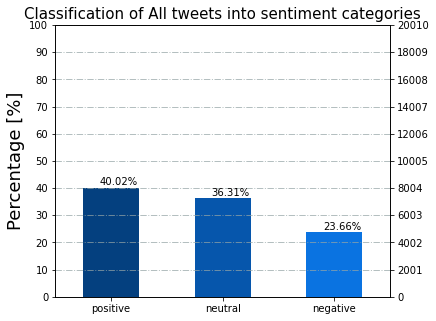

In [8]:
plt.figure(figsize=(6,5))
plt.title('Classification of All tweets into sentiment categories',fontsize=15)
plt.ylabel('Percentage [%]',fontsize=18)
ax = (df.sentiment.value_counts()/len(df)*100).plot(kind="bar", rot=0,color=['#04407F','#0656AC','#0A73E1'])
ax.set_yticks(np.arange(0, 110, 10))
plt.grid(color='#95a5a6', linestyle='-.', linewidth=1, axis='y', alpha=0.7)
ax2 = ax.twinx()
ax2.set_yticks(np.arange(0, 110, 10)*len(df)/100)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

Text(0, 0.5, 'Number of tweets')

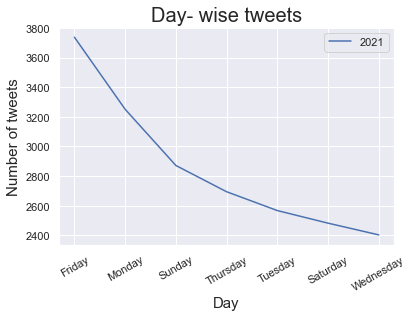

In [22]:
y=set(df['year'])
sns.set(style='darkgrid',)
for item in list(y):
    data=df[df['year']==item]['day'].value_counts().reindex()
    sns.lineplot(data = data,palette = "hot", legend="brief",label=item)
plt.xticks(rotation=30)
plt.legend()
plt.title('Day- wise tweets',fontsize = 20)
plt.xlabel('Day',fontsize = 15)
plt.ylabel('Number of tweets',fontsize = 15)

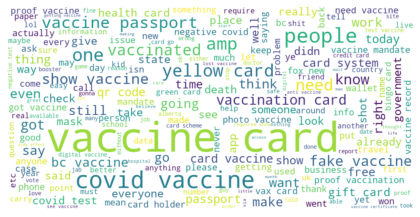

In [23]:
from wordcloud import WordCloud,ImageColorGenerator
text = " ".join(tweet for tweet in df['Processed Tweet'].astype(str))
wordcloud = WordCloud(
    background_color = 'white',
    width = 1000,
    height = 500).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.rcParams['figure.figsize'] = [20, 20]
plt.tight_layout()

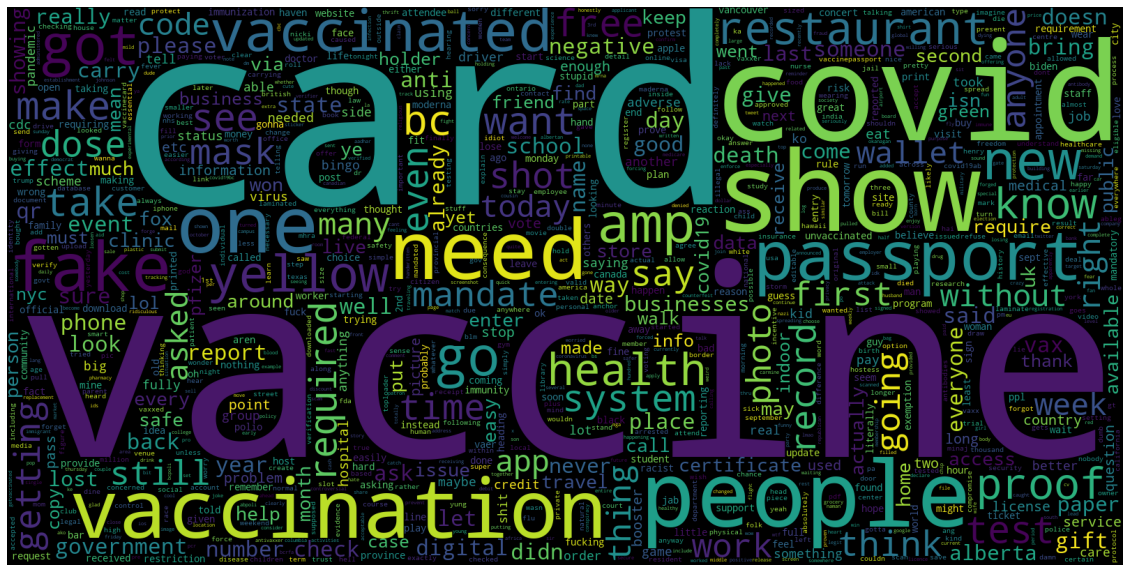

In [26]:
data_neg = df['Processed Tweet']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.axis('off')
plt.imshow(wc)

## MODEL TESTING

In [ ]:
data['tweet'] = data['tweet'].apply(lambda x: str(x))
data['tweet'] = data['tweet'].apply(lambda x: x.lower())
data['tweet'] = data['tweet'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

print(data[data['sentiment'] == 'pos'].size)
print(data[data['sentiment'] == 'cons'].size)



In [ ]:
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['tweet'].values)
X = tokenizer.texts_to_sequences(data['tweet'].values)
X = pad_sequences(X)

In [ ]:
X.shape[1]

In [ ]:
embed_dim = 128
lstm_out = 196

max_features=2000
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model.add(LSTM(lstm_out))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

In [ ]:
batch_size = 128
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

In [ ]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))

In [ ]:
validation_size = 10

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
CR=confusion_matrix(Y_test, y_train)

fig, ax = plot_confusion_matrix(conf_mat=CR, figsize=(10,10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)

plt.show()